## 0. Import Libraries

In [2]:
from datetime import datetime, timedelta
from glob import glob

import numpy as np
import pandas as pd
import pyproj
import rioxarray
import salem
import xarray as xr
from matplotlib.lines import Line2D
import matplotlib
from shapely.geometry import mapping

import cartopy
import cartopy.io.shapereader as shpreader 
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.patheffects as path_effects
import proplot
from matplotlib.colors import BoundaryNorm, ListedColormap
from cartopy.feature import ShapelyFeature
from dea_tools.spatial import xr_vectorize, xr_rasterize
from wrf import getvar, interpline, CoordPair, xy_to_ll, ll_to_xy 

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Data Options

In [3]:
general_path = 'data'
variable = 'LU_INDEX'

## 2. Open Data

### 2.1 Land-use

In [4]:
d01_luse = xr.open_dataset(fr'{general_path}/wrfinput_d01_LU_INDEX_urban.nc')[variable]
d02_luse = xr.open_dataset(fr'{general_path}/wrfinput_d02_LU_INDEX_urban.nc')[variable]

d03_luse_urban = xr.open_dataset(fr'{general_path}/wrfinput_d03_LU_INDEX_urban.nc')[variable]
d03_luse_nourban = xr.open_dataset(fr'{general_path}/wrfinput_d03_LU_INDEX_nourban.nc')[variable]

In [5]:
# assign projection and dim info
d01_luse = d01_luse.rio.write_crs(d01_luse.attrs['pyproj_srs'])
d01_luse = d01_luse.rio.set_spatial_dims(x_dim='west_east',
                             y_dim='south_north')

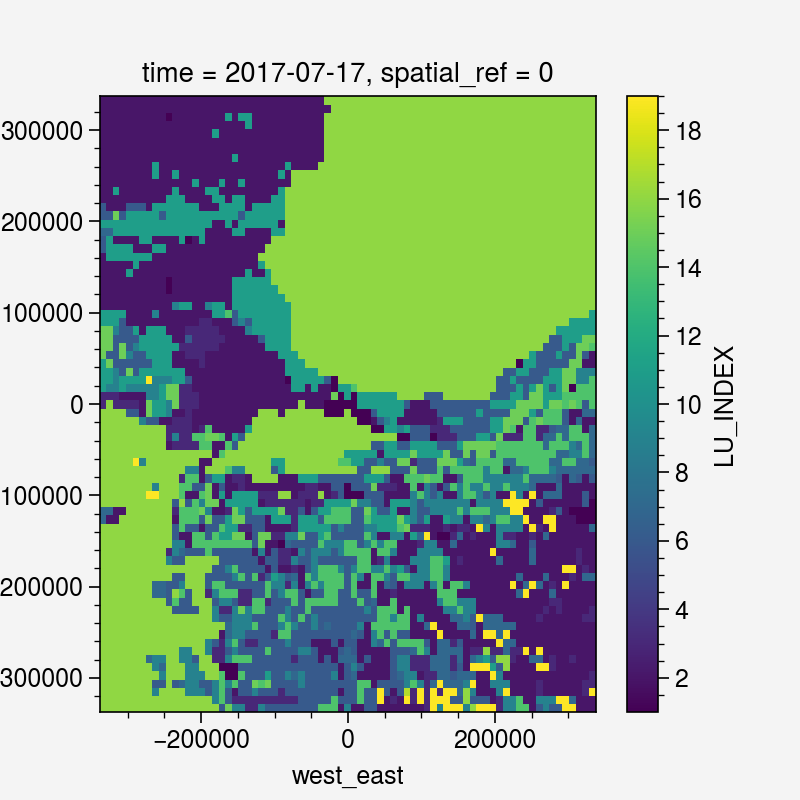

In [6]:
# example plot
d01_luse.plot()

### 2.2 DEM

In [7]:
ist_dem = rioxarray.open_rasterio(r'data/DEM/istanbul/istanbul_dem_clipped_city.tif',
                                  masked=True).squeeze()
ist_dem = ist_dem.rio.reproject('epsg:4326')

## 3. Plot

### 3.1 Options

In [8]:
# Parameters to change (plot) -------------------
# projection
proj = d01_luse.rio.crs.to_dict()
globe = cartopy.crs.Globe(ellipse='sphere', semimajor_axis=6370000, semiminor_axis=6370000)
lcc = cartopy.crs.LambertConformal(globe=globe, # important!
                            central_longitude=proj['lon_0'], 
                            central_latitude=proj['lat_0'],
                            standard_parallels=(proj['lat_1'], proj['lat_2']),
                            )

# fig features
fig_array = [[1, 2],
             [3, 4]
            ]
graphic_no = 4

In [9]:
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
import matplotlib.image as image
logo = image.imread('data/north_arrow.png')

### 3. Figure

In [10]:
# shapefile path names for:
shape_path = 'shapefiles'

# Istanbul - province
istanbul_shape = fr'{general_path}/{shape_path}/istanbul_without_districts.shp'
turkey_province_shape = r'data/shapefiles/Iller_HGK_6360_Kanun_Sonrasi.shp'

In [11]:
# color bar creation
cb_list = ['#f00',
           '#fffcd7',
           '#797100',
           '#009d86',
           '#70cdc0',
           '#c8bb27',
           '#00b900',
           '#009200',
           '#006900',
           '#9be3ff',
           '#929292',
           '#fcee81'
          ]

cb_list_hgt = ['#aeefd5',
               '#b5f6b2',
               '#e5fcb2',
               '#cbe684',
               '#54b93d',
               '#0c8c36', 
           '#508f3a',
           '#9fa528',
           '#efb60d',
           '#d86e02',
           '#a92a02',
           '#7e0400',
           '#741705',
           '#6c270a',
           '#703715',
          ]

labels = [
    'Urban Land',
    'Dryland, Cropland',
    'Irrigated Cropland',
    'Crops, Wood Mosaic',
    'Grassland',
    'Mix Shrubland',
    'Decidious Broadleaf Forest',
    'Evergreen Needleleaf Forest',
    'Mixed Forest',
    'Water Bodies',
    'Herbaceous Wetlands',
    'Barren or Sparsely Vegetated'
]

labels_hgt = [
    '0 - 30 meters',
    '30 - 60 meters',
    '60 - 90 meters',
    '90 - 120 meters',
    '120 - 150 meters',
    '150 - 180 meters',
    '180 - 210 meters',
    '210 - 240 meters',
    '240 - 270 meters',
    '270 - 300 meters',
    '300 - 330 meters',
    '330 - 360 meters',
    '360 - 390 meters',
    '390 - 420 meters',
    '420 - 450 meters',
]


# make a color map of fixed colors for land use
unique = np.unique(d03_luse_urban)
cmap = matplotlib.colors.ListedColormap(cb_list)
bounds= np.concatenate([np.array([0]), unique,])
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N,)

# make a color map of fixed colors for DEM
cmap_dem = matplotlib.colors.ListedColormap(cb_list_hgt)
norm_dem = matplotlib.colors.BoundaryNorm(np.arange(0, 450, 30), cmap_dem.N)
ticks = np.arange(0, 450, 90)

In [12]:
ticks

array([  0,  90, 180, 270, 360])

In [13]:
sol_alt = [40.08444595, 27.69171143]
sol_ust = [41.88309609, 27.65621552]
sag_ust = [41.88533872, 30.07234867]
sag_alt = [40.08662803, 30.04271274]

In [14]:
%%capture
# Create Figure -------------------------
fig, axs = proplot.subplots(fig_array, 
                            aspect=10,
                            axwidth=5,
                            proj=[lcc, lcc, lcc, lcc],
                            hratios=tuple(np.ones(len(fig_array), dtype=int)),
                            includepanels=True,
                            hspace=0.86,
                            wspace=0.56,
                            sharey=0)

# format whole figure
axs.format(abcloc='ul',
           #abcbbox = True,
           abc_kw={'size':20},
           abc=True,
           zorder=50)

# ankara limits d01
for i in range(1):
    axs[i].format(lonlim=(25.17547607, 32.7705094), 
               latlim=(38.41301575, 43.5944975), 
               longrid=False, 
               latgrid = False,
               labels = False,
               #lonlabels='t',
               #latlabels='r',
               #labelsize = 7,
               #lonlines=6,
               #latlines=2,
               zorder = 70)

# ankara limits d03
for i in range(1, 4):
    axs[i].format(lonlim=(27.69171143, 30.04271274-0.10),
                latlim=(40.08444595+0.20, 41.88309609-0.10), 
               longrid=False, 
               latgrid = False)
    
# shapefile
# add shapefiles to figure
    
# İstanbul - province
shape_feature_istanbul = ShapelyFeature(shpreader.Reader(istanbul_shape).geometries(),
                                      cartopy.crs.PlateCarree(), 
                                      facecolor='none', edgecolor = 'darkred',
                                      linewidth = 2.0, zorder = 30)

shape_feature_turkey = ShapelyFeature(shpreader.Reader(turkey_province_shape).geometries(),
                                      cartopy.crs.PlateCarree(), 
                                      facecolor='none', edgecolor = 'black',
                                      linewidth = 0.9, zorder = 30)

# add shapefiles as a feature
for i in range(4):
    axs[i].add_feature(shape_feature_istanbul)
    
for i in range(1, 4):
    axs[i].add_feature(shape_feature_turkey)


# External complementary shapefiles
shpfilename = shpreader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')

# external countries (shapefiles will be defined for these)
cts = ['Syria', 'Iraq', 'Iran',
       'Azerbaijan', 'Armenia',
       'Russia', 'Georgia',
       'Cyprus', 'Northern Cyprus',
       ]
    
# add external shapefile geometries
for country in shpreader.Reader(shpfilename).records():
    
    if country.attributes['ADMIN'] in cts:
        
        count_shp = country.geometry
        for i in range(1):
            axs[i].add_geometries([count_shp], cartopy.crs.PlateCarree(),
                              facecolor='white', edgecolor = 'black',
                              linewidth = 0.9, zorder = 9.5,)
                
                
    elif country.attributes['ADMIN'] == 'Turkey':
        
        tr = country.geometry
        for i in range(1):
            axs[i].add_geometries([tr], cartopy.crs.PlateCarree(),
                              edgecolor='black', linewidths=0.9,
                              facecolor='white', zorder=2)
            axs[i].add_geometries([tr], cartopy.crs.PlateCarree(),
                              edgecolor='black', linewidths=0.9,
                              facecolor='none', zorder=30)
    
    elif country.attributes['ADMIN'] == 'Bulgaria' or \
         country.attributes['ADMIN'] == 'Greece' or \
         country.attributes['ADMIN'] == 'Romania':
        
        count_shp = country.geometry
        for i in range(1):
            axs[i].add_geometries([count_shp], cartopy.crs.PlateCarree(),
                              facecolor='white', edgecolor = 'black',
                              linewidth = 0.9, zorder = 2.2,)
            axs[i].add_geometries([count_shp], cartopy.crs.PlateCarree(),
                              edgecolor='black', linewidths=0.9,
                              facecolor='none', zorder=30)
            
# facecolor
axs[0].set_facecolor("#9be3ff")

# Domain border lines on the map
left_bottom = [np.array([38.01301575, 25.17547607]),
               np.array([39.57168579, 27.04815674]),
               np.array([40.08444595, 27.69171143])]

left_top = [np.array([43.9944975 , 24.81346577]),
            np.array([42.4579201 , 26.96181025]),
            np.array([41.88309609, 27.65621552])]

right_bottom = [np.array([38.01301622, 32.7705094 ]),
                np.array([39.57342287, 30.79289761]),
                np.array([40.08662803, 30.04271274])]

right_top = [np.array([43.99449802, 33.1325184 ]),
             np.array([42.45973517, 30.87453939]),
             np.array([41.88533872, 30.07234867])]

# Domain name texts on the map
domain_list = ['', 'D2', 'D3']
for i, d_name in zip(range(3), domain_list):
    
    # domain 1
    axs[0].text(right_top[i][1], right_top[i][0]+0.05, domain_list[i],
            color='k', weight='bold', fontsize=13 ,
            transform = cartopy.crs.PlateCarree(), zorder = 15,
            horizontalalignment='right')
    
# domain borders for 1. axis
for i in range(1, 3):
    lw = 3
    axs[0].plot([left_bottom[i][1], left_top[i][1],], 
            [left_bottom[i][0], left_top[i][0],],
            c='k', linewidth=lw, zorder=10,
            transform = cartopy.crs.PlateCarree(),
            )
    
    axs[0].plot([left_top[i][1], right_top[i][1],],
            [left_top[i][0], right_top[i][0],],
            c='k', linewidth=lw, zorder=10,
            transform = cartopy.crs.PlateCarree())
    
    axs[0].plot([right_top[i][1], right_bottom[i][1],],
            [right_top[i][0], right_bottom[i][0],],
            c='k', linewidth=lw, zorder=10,
            transform = cartopy.crs.PlateCarree())
    
    axs[0].plot([right_bottom[i][1], left_bottom[i][1],],
            [right_bottom[i][0], left_bottom[i][0],],
            c='k', linewidth=lw, zorder=10,
            transform = cartopy.crs.PlateCarree())
    
    
# plots

# lu_index in d01
mesh = axs[0].pcolormesh(d01_luse['lon'].values, d01_luse['lat'].values,
                      d01_luse.values-0.5, norm=norm, cmap=cmap, 
                      transform=cartopy.crs.PlateCarree(), zorder=3)

# lu_index in d02
mesh = axs[0].pcolormesh(d02_luse['lon'].values, d02_luse['lat'].values,
                      d02_luse.values-0.5, norm=norm, cmap=cmap, 
                      transform=cartopy.crs.PlateCarree(), zorder=9)

# lu_index in d03
mesh = axs[0].pcolormesh(d03_luse_urban['lon'].values, d03_luse_urban['lat'].values,
                      d03_luse_urban.values-0.5, norm=norm, cmap=cmap, 
                      transform=cartopy.crs.PlateCarree(), zorder=9)

# option b
# lu_index in d03 (urban)
mesh = axs[2].pcolormesh(d03_luse_urban['lon'].values, d03_luse_urban['lat'].values,
                      d03_luse_urban.values-0.5, norm=norm, cmap=cmap, 
                      transform=cartopy.crs.PlateCarree(), zorder=0)

# option c
# lu_index in d03 (nourban)
mesh = axs[3].pcolormesh(d03_luse_urban['lon'].values, d03_luse_urban['lat'].values,
                      d03_luse_nourban.values-0.5, norm=norm, cmap=cmap, 
                      transform=cartopy.crs.PlateCarree(), zorder=0,)

# DEM axis 1
mesh_dem = axs[1].pcolormesh(ist_dem['x'].values, ist_dem['y'].values,
                      ist_dem, norm=norm_dem, cmap=cmap_dem, 
                      transform=cartopy.crs.PlateCarree(), zorder=0,)

# D3 title
axs[2:].format(title='D3',
              titleloc='ur')

custom_lines = []
for i, cb_col in enumerate(cb_list):

    custom_lines.append(Patch(facecolor=cb_col,
                               edgecolor='k',
                               label=labels[i]))
    
custom_lines_hgt = []
for i, cb_col in enumerate(cb_list_hgt):

    custom_lines_hgt.append(Patch(facecolor=cb_col,
                               edgecolor='k',
                               label=labels_hgt[i]))
    
# cs lines
lonlat_eu = [
    [[40.86667500, 28.33946944], [41.45058889, 28.88946111]],
    [[40.86667500, 28.43946944], [41.45058889, 28.98946111]],
    [[40.86667500, 28.53946944], [41.45058889, 29.08946111]],
    [[40.86667500, 28.63946944], [41.45058889, 29.18946111]],
    [[40.86667500, 28.73946944], [41.45058889, 29.28946111]],
]

lonlat_an = [
    [[40.81667500, 28.82280278], [41.40058889, 29.33946111]],
    [[40.81667500, 28.92280278], [41.40058889, 29.43946111]],
    [[40.81667500, 29.02280278], [41.40058889, 29.53946111]],
    [[40.81667500, 29.12280278], [41.40058889, 29.63946111]],
    [[40.81667500, 29.22280278], [41.40058889, 29.73946111]],
]

for i in range(5):
    axs[2].plot((lonlat_eu[i][0][1], lonlat_eu[i][1][1]),
                    (lonlat_eu[i][0][0], lonlat_eu[i][1][0]),
                         color='black', 
                         transform = cartopy.crs.PlateCarree(), 
                         zorder = 6, 
                         linewidth = 1.5, 
                         )
    axs[3].plot((lonlat_an[i][0][1], lonlat_an[i][1][1]),
                    (lonlat_an[i][0][0], lonlat_an[i][1][0]),
                         color='black', 
                         transform = cartopy.crs.PlateCarree(), 
                         zorder = 6, 
                         linewidth = 1.5, 
                         )
    
    for k in range(2):
        axs[2].scatter(lonlat_eu[i][k][1], lonlat_eu[i][k][0],  
                           color='white', 
                           transform = cartopy.crs.PlateCarree(),
                           zorder = 7,
                           s = 70,
                           marker = '.',
                           markeredgecolor='k')
        axs[3].scatter(lonlat_an[i][k][1], lonlat_an[i][k][0],  
                           color='white', 
                           transform = cartopy.crs.PlateCarree(),
                           zorder = 7,
                           s = 70,
                           marker = '.',
                           markeredgecolor='k')
        
# cs line text for AN
for i in range(2):
    
    lon_txt = lonlat_an[2][i][1]
    
    if i == 0:
        lat_txt = lonlat_an[2][i][0]-0.06
        txt = 'AN: A'
    elif i == 1:
        lat_txt = lonlat_an[2][i][0]+0.06
        txt = 'AN: B'
        
    axs[3].text(lon_txt, lat_txt,
                     s = txt,
                     size = 12,
                     border=True,
                     bordercolor='black',
                     borderwidth=2,
                     color='white', 
                     transform = cartopy.crs.PlateCarree(),
                     va='center', 
                     weight='bold', 
                     ha = 'center', 
                     path_effects=[path_effects.Stroke(linewidth=2, foreground='black'),
                                   path_effects.Normal()]
                     )
    
for i in range(2):
    
    lon_txt = lonlat_eu[2][i][1]
    
    if i == 0:
        lat_txt = lonlat_eu[2][i][0]-0.06
        txt = 'EU: A'
    elif i == 1:
        lat_txt = lonlat_eu[2][i][0]+0.06
        txt = 'EU: B'
        
    axs[2].text(lon_txt, lat_txt,
                     s = txt,
                     size = 12,
                     border=True,
                     bordercolor='black',
                     borderwidth=2,
                     color='white', 
                     transform = cartopy.crs.PlateCarree(),
                     va='center', 
                     weight='bold', 
                     ha = 'center', 
                     path_effects=[path_effects.Stroke(linewidth=2, foreground='black'),
                                   path_effects.Normal()]
                     )

# colorbars
axs[1].colorbar(mesh_dem,
                 label='meters',
                 loc='ur', length=24,  # length is em widths
                 tickminor=True, framealpha=1,
                 framecolor = 'white',
                 width=1.1,
                 labelsize = 12,
                 ticklabelsize = 12,
                frame=False,
                )

leg = axs[3].legend(custom_lines, 
           labels=labels,
           fontsize=20,
           ncols = 2,
           space = -9.6,
           loc = 'bottom',
           alpha=1,
           prop={'size': 9.28,
                 })

# add logo
imagebox = OffsetImage(logo, zoom = 0.15, transform=cartopy.crs.PlateCarree())
ab = AnnotationBbox(imagebox, [512*2,500*2],
                    frameon = False,
                    xycoords = 'axes pixels'
                    )
axs[1].add_artist(ab)

#save figure
plt.savefig(r'pictures/Figure1.jpeg',
            bbox_inches='tight', optimize=True,
            progressive=True, dpi=800)